In [42]:
import time
import os
import cv2

import numpy as np


import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import timm
import albumentations as A
from PIL import Image
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

In [43]:
# # Define the transformations you want to apply
# image_transforms = {
#     'train': A.Compose([
#         A.Rotate(limit=45, p=0.5, border_mode=cv2.BORDER_CONSTANT),
#         A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
#         A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.0, rotate_limit=0, p=0.5),
#         A.GaussNoise(var_limit=(5.0, 20.0), p=0.5),
#         A.Normalize(mean=[0.5], std=[0.5]),
#         ToTensorV2(),
#     ]),
    
#     'val': A.Compose([
#         A.Normalize(mean=[0.5], std=[0.5]),
#         ToTensorV2(),
#     ]),
#     'test': A.Compose([
#         A.Normalize(mean=[0.5], std=[0.5]),
#         ToTensorV2(),
#     ]),
# }

In [44]:
import numpy as np

NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])

image_transforms = {
    'train': A.Compose([
        A.Rotate(limit=45, p=0.5, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.0, rotate_limit=0, p=0.5),
        A.GaussNoise(var_limit=(5.0, 20.0), p=0.5),
        A.Normalize(mean=NORM_MEAN.tolist(), std=NORM_STD.tolist()),  # Use specified mean and std
        ToTensorV2(),
    ]),
    
    'val': A.Compose([
        A.Normalize(mean=NORM_MEAN.tolist(), std=NORM_STD.tolist()),  # Use specified mean and std
        ToTensorV2(),
    ]),
    'test': A.Compose([
        A.Normalize(mean=NORM_MEAN.tolist(), std=NORM_STD.tolist()),  # Use specified mean and std
        ToTensorV2(),
    ]),
}


In [45]:
CUDA_LAUNCH_BLOCKING=1

In [46]:
torch.cuda.empty_cache()


In [47]:
!gpustat

SJP-DIT400TR-55L     Fri Apr  5 16:03:59 2024  545.23.08
[0] Quadro RTX 8000  | 70'C,  45 % | 15715 / 49152 MB | debarghya(4906M) pallavi(9062M) aritra(536M) soumajit(332M) soumajit(165M)


In [48]:
class CustomImgFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        super(CustomImgFolder, self).__init__()   # Equivalent to Dataset.__init__(self).
        self.data = []
        self.root_dir = root_dir
        self.classes = [name for name in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, name)) and not name.startswith('.')]
        self.transform = transform

        for i, name in enumerate(self.classes):
            all_files = os.listdir(os.path.join(root_dir, name))
            for file in tqdm(all_files, desc=f"Loading {name}"):
                image = np.array(Image.open(os.path.join(root_dir, name, file)))
                self.data.append((image, i))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        image, label = self.data[i]
        if self.transform is not None:
            augs = self.transform(image=image)
            image = augs["image"]

        return image, label


In [49]:
train_folder_path = '/home/aritra/AML_Files/faces_train'
valid_folder_path = '/home/aritra/AML_Files/faces_Valid'
test_folder_path = '/home/aritra/AML_Files/faces_Test'

In [50]:
train_dataset = CustomImgFolder(root_dir=train_folder_path,transform=image_transforms['train'])

Loading Sanjib Patra : 100%|██████████████████████| 67/67 [00:00<00:00, 1072.25it/s]


In [51]:
valid_dataset = CustomImgFolder(root_dir =valid_folder_path,transform=image_transforms['val'])

Loading Sanjib Patra : 100%|██████████████████████| 21/21 [00:00<00:00, 1044.61it/s]


In [52]:
test_dataset = CustomImgFolder(root_dir =test_folder_path,transform=image_transforms['test'])

Loading Sanjib Patra : 100%|████████████████████████| 8/8 [00:00<00:00, 1007.46it/s]


In [53]:
train_samples = len(train_dataset)
valid_samples = len(valid_dataset)
test_samples = len(test_dataset)
print(f"Train Samples :{train_samples}\n Valid Samples : {valid_samples} \n test Samples : {test_samples}")

Train Samples :1863
 Valid Samples : 546 
 test Samples : 238


In [54]:
train_samples= len(train_dataset)
val_samples= len(valid_dataset)
test_samples = len(test_dataset)

In [55]:
# Assuming 'train_dataset', 'valid_dataset', and 'test_dataset' are defined datasets
batch_size = 32  # Example batch size, you may have used a different value

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [56]:
def show_images(images, labels, class_names):
    num_rows = 4
    num_cols = 8
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            ax = axes[i, j]
            ax.imshow(images[index].permute(1, 2, 0))
            ax.set_title(class_names[labels[index].item()])
            ax.axis('off')

    plt.tight_layout()
    plt.show()

torch.Size([32, 3, 160, 160])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

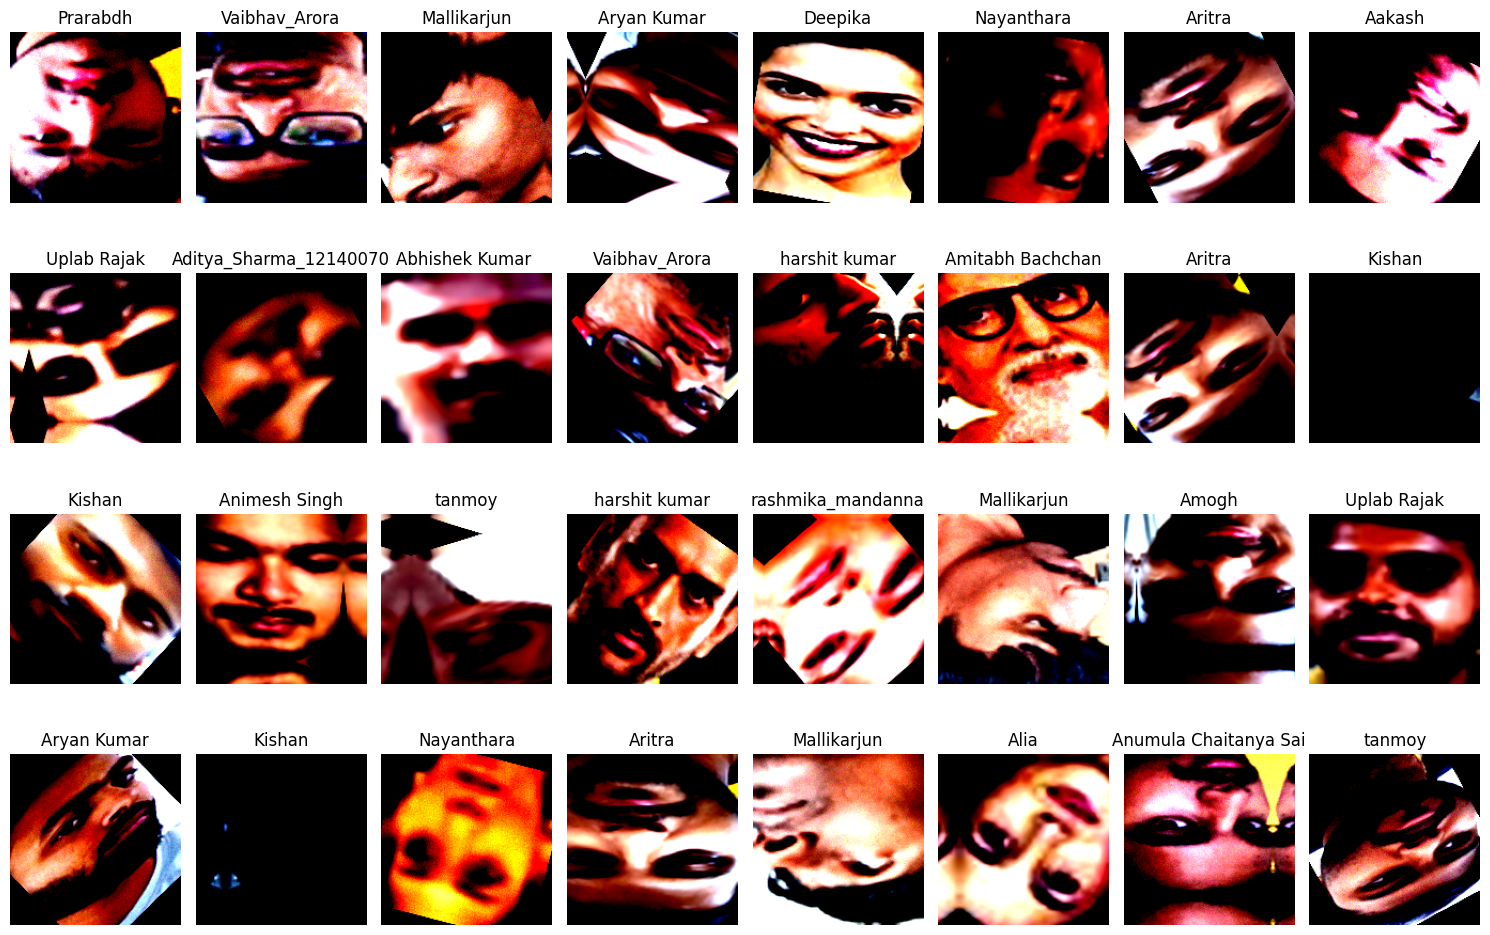

In [57]:
# Get a batch of images and labels from the train_loader
images, labels = next(iter(train_loader))
class_names = train_dataset.classes

print(images.shape)
# Display images in a grid
show_images(images, labels, class_names)


## Model Creation

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [59]:
class BasicBlock(nn.Module):
    
    expansion = 1
    def __init__(self,in_channels,out_channels,indentity_downsample = None, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,stride =stride,padding =1 , bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,stride = 1,padding =1 , bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.indentity_downsample = indentity_downsample
        self.stride =  stride
        self.relu = nn.ReLU()


    def forward(self,x):
        identity = x.clone()

        x = self.conv1(x)
        x =  self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x =  self.bn2(x)

        if self.indentity_downsample is not None:
            identity = self.indentity_downsample(identity)
        # Handle dimension matching with LambdaLayer (as in option A of the first code)
        if self.stride != 1:
            padding = self.out_channels-x.shape[1]
            identity = F.pad(identity, (0, 0, 0, 0, 0, padding, 0, 0))


        x +=identity
        x = self.relu(x)
        return x






In [60]:
class ResNet(nn.Module):

    def __init__(self,BasicBlock,num_blocks,no_classes = 10):
        super(ResNet, self).__init__()
        self.in_channels = 16

        self.conv1 = nn.Conv2d(
            3, 16 , kernel_size = 3 , stride=1, padding=1 , bias = False
        )
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()

        self.layer1 = self.make_layer(BasicBlock, 16, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(BasicBlock, 32, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(BasicBlock, 64, num_blocks[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(64,no_classes)


    def forward(self,x):
        x = self.conv1(x)
        x= self.bn1(x)
        x = self.relu(x)


        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)


        x = self.avgpool(x)
        x = x.reshape(x.shape[0],-1)
        x = self.fc(x)

        return x


    def make_layer(self, BasicBlock, out_channels, num_residual_blocks, stride):
            layers = []

            if stride != 1 or self.in_channels != out_channels * BasicBlock.expansion:
                identity_downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(out_channels * BasicBlock.expansion)
                )
            else:
                identity_downsample = None

            layers.append(BasicBlock(self.in_channels, out_channels, identity_downsample, stride))
            self.in_channels = out_channels * BasicBlock.expansion

            for i in range(num_residual_blocks - 1):
                layers.append(BasicBlock(self.in_channels, out_channels))

            return nn.Sequential(*layers)








In [61]:
def ResNet56(num_classes):
    return ResNet(BasicBlock, [9,9,9], num_classes)

resnet56_model = ResNet56(num_classes=27)

In [62]:
resnet56_model.to(device)
summary(resnet56_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
       BasicBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

In [63]:
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet56_model.parameters(),lr= learning_rate,weight_decay=0.0001 ,betas=(0.9,0.999),eps=1e-7)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1 , patience=10)

In [64]:
X, y = next(iter(train_loader))
print(X)
X = X.to(device,dtype = torch.float32)
y = y.to(device)

predictions = resnet56_model(X)
print(f"This is the actual prediction my model makes{predictions.shape}")
softmax_predictions = F.softmax(predictions, dim=1)
prediction_classes = torch.argmax(softmax_predictions, dim=1)
print(f"This is predictions after argmax:\n{prediction_classes}")
print(f"This is y = {y} \\ and length of y is {len(y)} ")

criterion(predictions,y)

tensor([[[[-1.3987,  0.0056,  0.5707,  ..., -1.1589, -1.1760, -1.1760],
          [-1.8610, -0.6452,  0.5707,  ..., -1.5357, -1.2788, -1.1932],
          [-2.1008, -1.2788,  0.1426,  ..., -2.0494, -1.9124, -1.6042],
          ...,
          [ 1.5468,  1.5810,  1.6153,  ..., -2.1179, -1.6213, -0.5596],
          [ 1.5125,  1.5297,  1.5468,  ..., -2.1179, -1.9638, -1.1075],
          [ 1.4783,  1.4783,  1.4954,  ..., -2.1179, -2.1008, -1.6042]],

         [[-1.5280, -0.5651, -0.1625,  ..., -1.2304, -1.2304, -1.2304],
          [-1.8606, -1.0028, -0.1625,  ..., -1.5280, -1.3179, -1.2304],
          [-2.0182, -1.4580, -0.4601,  ..., -1.9832, -1.8431, -1.5805],
          ...,
          [ 1.0630,  1.1155,  1.1506,  ..., -2.0357, -1.7031, -0.9853],
          [ 1.0280,  1.0630,  1.0805,  ..., -2.0357, -1.9307, -1.3529],
          [ 0.9930,  1.0280,  1.0455,  ..., -2.0357, -2.0182, -1.6856]],

         [[-1.4559, -0.8110, -0.5321,  ..., -1.1247, -1.1247, -1.1247],
          [-1.6824, -1.1073, -

tensor(3.4027, device='cuda:0', grad_fn=<NllLossBackward0>)

In [65]:
def Trainfun(model, lossfun, optimizer, train_loader, valid_loader, num_epochs=20, patience = 7):
    # Initializing losses and metrics
    trainLoss = []
    valLoss = []
    trainAcc = []
    valAcc = []
    min_loss = np.inf
    best_model_state=None
    no_improvment_count = 0

    # Loop over epochs
    for epoch in range(num_epochs):
        train_running_loss = 0
        correct_train = 0

        # Set the network to training mode
        model.train()


        train_loader = tqdm(train_loader, desc="Training_batch1")
        # Loop over training data batches
        for X, y in train_loader:
            X = X.to(device) # dtype = torch.float32
            y = y.to(device)

            optimizer.zero_grad()

            # Forward pass
            y_hat = model(X)

            # Calculate the loss
            loss = lossfun(y_hat, y)

            # Backward pass and optimization step

            loss.backward()
            optimizer.step()

            _,predicted_outputs = torch.max(y_hat.data,1)

            correct_train += (predicted_outputs == y).float().sum().item()
            
            train_running_loss += (loss.data.item() * X.shape[0])



        # Calculate average loss and accuracy across batches
        train_epoch_loss = train_running_loss / train_samples
        trainLoss.append(train_epoch_loss)
        train_acc = correct_train / train_samples
        trainAcc.append(train_acc)




        model.eval()
        val_running_loss =0
        correct_val =0

        valid_loader = tqdm(valid_loader, desc="Validation_batch1")
        with torch.no_grad():

          # Loop over validation data batches
          for X, y in valid_loader:
              X = X.to(device)
              y = y.to(device)

              # Forward pass
              y_hat = model(X)
              loss = criterion(y_hat, y)
            
              _,predicted_outputs = torch.max(y_hat.data,dim=1)
              correct_val += (predicted_outputs == y).float().sum().item()
              val_running_loss += (loss.data.item()* X.shape[0])

          # Calculate average loss and accuracy across batches
          val_running_loss += (loss.data.item()* X.shape[0])
          val_epoch_loss = val_running_loss / valid_samples
          valLoss.append(val_epoch_loss)
          val_acc = correct_val / valid_samples
          valAcc.append(val_acc)

        info = "[Epoch {}/{}]: train-loss = {:0.6f} | train-acc = {:0.3f} | val-loss = {:0.6f} | val-acc = {:0.3f}"
        print(info.format(epoch + 1, num_epochs, train_epoch_loss, train_acc, val_epoch_loss, val_acc))

        # Updating the learning rate based on validation loss
        scheduler.step(val_epoch_loss)

        if val_epoch_loss < min_loss:
            min_loss = val_epoch_loss
            best_model_state = model.state_dict()
            no_improvment_count =0
        else:
            no_improvment_count +=1
        
        if no_improvment_count >= patience:
            print("Early stopping: No improvement for {} epochs.".format(patience))
            break


    return trainLoss, valLoss, trainAcc, valAcc, best_model_state



In [67]:
trainLoss, valLoss, trainAcc, valAcc,best_model_state = Trainfun(resnet56_model, lossfun= criterion, optimizer = optimizer, train_loader = train_loader, valid_loader = valid_loader, num_epochs=60 , patience= 15)

Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.72it/s]


[Epoch 1/60]: train-loss = 0.602162 | train-acc = 0.808 | val-loss = 0.947930 | val-acc = 0.722


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.68it/s]


[Epoch 2/60]: train-loss = 0.606233 | train-acc = 0.800 | val-loss = 0.952929 | val-acc = 0.701


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.68it/s]


[Epoch 3/60]: train-loss = 0.597110 | train-acc = 0.809 | val-loss = 0.862351 | val-acc = 0.727


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.62it/s]


[Epoch 4/60]: train-loss = 0.581773 | train-acc = 0.808 | val-loss = 0.894026 | val-acc = 0.705


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.65it/s]


[Epoch 5/60]: train-loss = 0.607058 | train-acc = 0.800 | val-loss = 0.859977 | val-acc = 0.744


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.78it/s]


[Epoch 6/60]: train-loss = 0.587275 | train-acc = 0.813 | val-loss = 0.853379 | val-acc = 0.742


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.90it/s]


[Epoch 7/60]: train-loss = 0.592092 | train-acc = 0.815 | val-loss = 0.865653 | val-acc = 0.731


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.58it/s]


[Epoch 8/60]: train-loss = 0.541231 | train-acc = 0.830 | val-loss = 0.794304 | val-acc = 0.766


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.46it/s]


[Epoch 9/60]: train-loss = 0.580680 | train-acc = 0.803 | val-loss = 0.814546 | val-acc = 0.753


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.61it/s]


[Epoch 10/60]: train-loss = 0.559532 | train-acc = 0.823 | val-loss = 0.823828 | val-acc = 0.745


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.67it/s]


[Epoch 11/60]: train-loss = 0.557780 | train-acc = 0.817 | val-loss = 0.790088 | val-acc = 0.756


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.70it/s]


[Epoch 12/60]: train-loss = 0.533329 | train-acc = 0.824 | val-loss = 0.804816 | val-acc = 0.756


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.68it/s]


[Epoch 13/60]: train-loss = 0.529465 | train-acc = 0.832 | val-loss = 0.737011 | val-acc = 0.777


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.84it/s]


[Epoch 14/60]: train-loss = 0.527649 | train-acc = 0.828 | val-loss = 0.910095 | val-acc = 0.729


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.72it/s]


[Epoch 15/60]: train-loss = 0.554738 | train-acc = 0.809 | val-loss = 0.752757 | val-acc = 0.762


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.86it/s]


[Epoch 16/60]: train-loss = 0.524817 | train-acc = 0.827 | val-loss = 0.802845 | val-acc = 0.751


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.58it/s]


[Epoch 17/60]: train-loss = 0.532266 | train-acc = 0.829 | val-loss = 0.761704 | val-acc = 0.771


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.50it/s]


[Epoch 18/60]: train-loss = 0.510801 | train-acc = 0.834 | val-loss = 0.856639 | val-acc = 0.755


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.62it/s]


[Epoch 19/60]: train-loss = 0.520849 | train-acc = 0.834 | val-loss = 0.740625 | val-acc = 0.769


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.73it/s]


[Epoch 20/60]: train-loss = 0.507591 | train-acc = 0.837 | val-loss = 0.748408 | val-acc = 0.777


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.63it/s]


[Epoch 21/60]: train-loss = 0.488883 | train-acc = 0.849 | val-loss = 0.790358 | val-acc = 0.747


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.74it/s]


[Epoch 22/60]: train-loss = 0.519706 | train-acc = 0.837 | val-loss = 0.823285 | val-acc = 0.747


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.69it/s]


[Epoch 23/60]: train-loss = 0.482136 | train-acc = 0.841 | val-loss = 0.878055 | val-acc = 0.734


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.64it/s]


[Epoch 24/60]: train-loss = 0.516693 | train-acc = 0.835 | val-loss = 0.908419 | val-acc = 0.727


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.88it/s]


[Epoch 25/60]: train-loss = 0.419804 | train-acc = 0.872 | val-loss = 0.680785 | val-acc = 0.786


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.47it/s]


[Epoch 26/60]: train-loss = 0.385895 | train-acc = 0.881 | val-loss = 0.680489 | val-acc = 0.784


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.48it/s]


[Epoch 27/60]: train-loss = 0.371124 | train-acc = 0.887 | val-loss = 0.670082 | val-acc = 0.793


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.76it/s]


[Epoch 28/60]: train-loss = 0.366717 | train-acc = 0.896 | val-loss = 0.673684 | val-acc = 0.786


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.43it/s]


[Epoch 29/60]: train-loss = 0.356581 | train-acc = 0.899 | val-loss = 0.671395 | val-acc = 0.797


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.74it/s]


[Epoch 30/60]: train-loss = 0.363513 | train-acc = 0.893 | val-loss = 0.678903 | val-acc = 0.791


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.67it/s]


[Epoch 31/60]: train-loss = 0.362377 | train-acc = 0.896 | val-loss = 0.669758 | val-acc = 0.789


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.84it/s]


[Epoch 32/60]: train-loss = 0.342426 | train-acc = 0.900 | val-loss = 0.659654 | val-acc = 0.793


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.78it/s]


[Epoch 33/60]: train-loss = 0.353988 | train-acc = 0.893 | val-loss = 0.667860 | val-acc = 0.788


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.96it/s]


[Epoch 34/60]: train-loss = 0.356738 | train-acc = 0.896 | val-loss = 0.658754 | val-acc = 0.789


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.67it/s]


[Epoch 35/60]: train-loss = 0.348200 | train-acc = 0.904 | val-loss = 0.665473 | val-acc = 0.795


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.45it/s]


[Epoch 36/60]: train-loss = 0.345948 | train-acc = 0.903 | val-loss = 0.675882 | val-acc = 0.789


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.47it/s]


[Epoch 37/60]: train-loss = 0.354777 | train-acc = 0.896 | val-loss = 0.667439 | val-acc = 0.791


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.71it/s]


[Epoch 38/60]: train-loss = 0.360996 | train-acc = 0.893 | val-loss = 0.668895 | val-acc = 0.797


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.52it/s]


[Epoch 39/60]: train-loss = 0.336146 | train-acc = 0.904 | val-loss = 0.661312 | val-acc = 0.802


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.85it/s]


[Epoch 40/60]: train-loss = 0.342247 | train-acc = 0.900 | val-loss = 0.678740 | val-acc = 0.793


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.69it/s]


[Epoch 41/60]: train-loss = 0.338370 | train-acc = 0.903 | val-loss = 0.661617 | val-acc = 0.793


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.74it/s]


[Epoch 42/60]: train-loss = 0.348064 | train-acc = 0.902 | val-loss = 0.668715 | val-acc = 0.791


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.85it/s]


[Epoch 43/60]: train-loss = 0.356058 | train-acc = 0.895 | val-loss = 0.668053 | val-acc = 0.802


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.89it/s]


[Epoch 44/60]: train-loss = 0.338905 | train-acc = 0.903 | val-loss = 0.667199 | val-acc = 0.791


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.71it/s]


[Epoch 45/60]: train-loss = 0.340273 | train-acc = 0.912 | val-loss = 0.667709 | val-acc = 0.793


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.84it/s]


[Epoch 46/60]: train-loss = 0.328303 | train-acc = 0.909 | val-loss = 0.663972 | val-acc = 0.789


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.85it/s]


[Epoch 47/60]: train-loss = 0.327260 | train-acc = 0.908 | val-loss = 0.669126 | val-acc = 0.788


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.83it/s]


[Epoch 48/60]: train-loss = 0.334198 | train-acc = 0.901 | val-loss = 0.665082 | val-acc = 0.791


Validation_batch1: 100%|████████████████████████████| 18/18 [00:01<00:00, 13.80it/s]

[Epoch 49/60]: train-loss = 0.332443 | train-acc = 0.906 | val-loss = 0.670478 | val-acc = 0.795
Early stopping: No improvement for 15 epochs.


In [68]:
model_save_path = "/home/aritra/AML_Files/Models/resnet56_3.pth"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

torch.save(best_model_state, model_save_path)


In [69]:
model_save_path = "/home/aritra/AML_Files/Models/resnet56_3.pth"


In [70]:
def calculate_test_accuracy(model):
    correct = 0
    test_samples = len(test_loader.dataset)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Make predictions.
            prediction = model(inputs)

            # Retrieve predictions indexes.
            _, predicted_class = torch.max(prediction.data, 1)

            # Compute the number of correct predictions.
            correct += (predicted_class == labels).float().sum().item()

    test_accuracy = correct / test_samples
    return test_accuracy

In [71]:
model= ResNet56(27)
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [73]:
model.eval().cuda()
accuracy = calculate_test_accuracy(model)
accuracy

0.7983193277310925

In [74]:
def calculate_class_accuracy(model):
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Make predictions.
            prediction = model(inputs)

            # Retrieve predictions indexes.
            _, predicted_class = torch.max(prediction.data, 1)

            # Compute per-class correct predictions.
            correct = (predicted_class == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] for i in range(num_classes)]
    return class_accuracy



In [77]:
num_classes = len(train_dataset.classes)
num_classes

27

In [78]:
def calculate_class_accuracy(model):
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Make predictions.
            prediction = model(inputs)

            # Retrieve predictions indexes.
            _, predicted_class = torch.max(prediction.data, 1)

            # Compute per-class correct predictions.
            correct = (predicted_class == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] for i in range(num_classes)]
    return class_accuracy

class_accuracy = calculate_class_accuracy(model)
for i in range(num_classes):
    print(f'Class {i} Accuracy: {class_accuracy[i]:.4f}')


Class 0 Accuracy: 0.5000
Class 1 Accuracy: 0.6250
Class 2 Accuracy: 1.0000
Class 3 Accuracy: 1.0000
Class 4 Accuracy: 1.0000
Class 5 Accuracy: 0.6364
Class 6 Accuracy: 0.2222
Class 7 Accuracy: 0.5385
Class 8 Accuracy: 0.2222
Class 9 Accuracy: 1.0000
Class 10 Accuracy: 1.0000
Class 11 Accuracy: 0.8333
Class 12 Accuracy: 1.0000
Class 13 Accuracy: 0.2000
Class 14 Accuracy: 1.0000
Class 15 Accuracy: 0.4000
Class 16 Accuracy: 1.0000
Class 17 Accuracy: 0.8571
Class 18 Accuracy: 1.0000
Class 19 Accuracy: 1.0000
Class 20 Accuracy: 1.0000
Class 21 Accuracy: 0.9000
Class 22 Accuracy: 1.0000
Class 23 Accuracy: 0.5556
Class 24 Accuracy: 1.0000
Class 25 Accuracy: 1.0000
Class 26 Accuracy: 0.6250


In [79]:
!gpustat

SJP-DIT400TR-55L     Fri Apr  5 16:43:40 2024  545.23.08
[0] Quadro RTX 8000  | 69'C,  45 % | 23171 / 49152 MB | debarghya(4906M) pallavi(9062M) aritra(536M) aritra(7456M) soumajit(332M) soumajit(165M)


## Making the unknown functionality

In [80]:
def predict_and_show_image(model, image_path, classes, threshold=0.7):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
        
    ])
    input_image = transform(image).unsqueeze(0).to(device)

    # Make predictions
    with torch.no_grad():
        model.eval()
        predictions = model(input_image)

    # Retrieve predicted probabilities
    probabilities = torch.nn.functional.softmax(predictions, dim=1)
    max_probability, predicted_class = torch.max(probabilities, 1)

    # Check if the maximum probability is below the threshold
    if max_probability.item() < threshold:
        print(f"The image is unknown with a probability of {max_probability.item():.2%}")
        show_image(image)
    else:
        class_name = classes[predicted_class.item()]
        print(f"The image belongs to class {class_name} with a probability of {max_probability.item():.2%}")
        show_image(image)

In [81]:
def show_image(image):
    np_image = np.array(image)
    # Display the image
    plt.imshow(np_image)
    plt.axis('off')
    plt.show()

The image is unknown with a probability of 58.95%


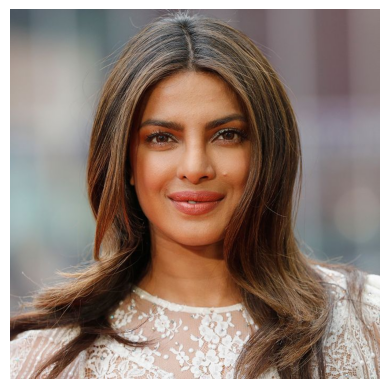

In [84]:
image_path = "/home/aritra/AML_Files/priyanka_chopra.jpg"
predict_and_show_image(model, image_path, train_dataset.classes, threshold=0.7)


In [20]:
def ResNet20(num_classes):
    return ResNet(BasicBlock, [3,3,3], num_classes)

resnet20_model = ResNet20(num_classes=27)

In [21]:
resnet20_model.to(device)
summary(resnet20_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
       BasicBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

In [22]:
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet20_model.parameters(),lr= learning_rate,weight_decay=0.0001 ,betas=(0.9,0.999),eps=1e-7)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1 , patience=10)

In [23]:
X, y = next(iter(train_loader))
print(X)
X = X.to(device,dtype = torch.float32)
y = y.to(device)

predictions = resnet20_model(X)
print(f"This is the actual prediction my model makes{predictions.shape}")
softmax_predictions = F.softmax(predictions, dim=1)
prediction_classes = torch.argmax(softmax_predictions, dim=1)
print(f"This is predictions after argmax:\n{prediction_classes}")
print(f"This is y = {y} \\ and length of y is {len(y)} ")

criterion(predictions,y)

tensor([[[[ 7.3333e-01,  6.7843e-01,  6.1569e-01,  ..., -6.9412e-01,
           -7.0980e-01, -6.9412e-01],
          [ 7.4118e-01,  6.9412e-01,  6.3137e-01,  ..., -6.7059e-01,
           -6.7059e-01, -6.3922e-01],
          [ 7.3333e-01,  6.9412e-01,  6.3922e-01,  ..., -6.3922e-01,
           -6.3137e-01, -5.8431e-01],
          ...,
          [-7.6471e-01, -8.0392e-01, -8.2745e-01,  ...,  4.3137e-02,
           -3.5294e-02, -1.0588e-01],
          [-7.7255e-01, -8.1176e-01, -8.3529e-01,  ...,  5.8824e-02,
           -2.7451e-02, -9.8039e-02],
          [-7.8039e-01, -8.1961e-01, -8.4314e-01,  ...,  6.6667e-02,
           -1.9608e-02, -1.0588e-01]],

         [[ 1.7600e+02,  1.7000e+02,  1.6300e+02,  ...,  1.7000e+01,
            1.7000e+01,  2.0000e+01],
          [ 1.7500e+02,  1.7000e+02,  1.6500e+02,  ...,  1.8000e+01,
            2.0000e+01,  2.4000e+01],
          [ 1.7400e+02,  1.7000e+02,  1.6500e+02,  ...,  2.0000e+01,
            2.3000e+01,  2.9000e+01],
          ...,
     

tensor(3.6944, device='cuda:0', grad_fn=<NllLossBackward0>)

In [28]:
trainLoss, valLoss, trainAcc, valAcc,best_model_state = Trainfun(resnet20_model, lossfun= criterion, optimizer = optimizer, train_loader = train_loader, valid_loader = valid_loader, num_epochs=60 , patience= 15)

Validation_batch1: 100%|███| 18/18 [00:00<00:00, 36.80it/s]


[Epoch 1/60]: train-loss = 1.143288 | train-acc = 0.663 | val-loss = 1.159859 | val-acc = 0.628


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.57it/s]


[Epoch 2/60]: train-loss = 1.120913 | train-acc = 0.674 | val-loss = 1.202952 | val-acc = 0.648


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.90it/s]


[Epoch 3/60]: train-loss = 1.093894 | train-acc = 0.683 | val-loss = 1.106150 | val-acc = 0.687


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.46it/s]


[Epoch 4/60]: train-loss = 1.103969 | train-acc = 0.683 | val-loss = 1.089450 | val-acc = 0.665


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 35.05it/s]


[Epoch 5/60]: train-loss = 1.102846 | train-acc = 0.676 | val-loss = 1.135397 | val-acc = 0.647


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.96it/s]


[Epoch 6/60]: train-loss = 1.084886 | train-acc = 0.684 | val-loss = 1.138052 | val-acc = 0.663


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 36.24it/s]


[Epoch 7/60]: train-loss = 1.091491 | train-acc = 0.688 | val-loss = 1.170458 | val-acc = 0.641


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 36.52it/s]


[Epoch 8/60]: train-loss = 1.060568 | train-acc = 0.691 | val-loss = 1.079865 | val-acc = 0.665


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 36.03it/s]


[Epoch 9/60]: train-loss = 1.037193 | train-acc = 0.696 | val-loss = 1.097946 | val-acc = 0.672


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 36.35it/s]


[Epoch 10/60]: train-loss = 1.093488 | train-acc = 0.673 | val-loss = 1.125705 | val-acc = 0.650


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.91it/s]


[Epoch 11/60]: train-loss = 1.051327 | train-acc = 0.693 | val-loss = 1.055101 | val-acc = 0.659


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.46it/s]


[Epoch 12/60]: train-loss = 1.033373 | train-acc = 0.697 | val-loss = 1.040562 | val-acc = 0.665


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 38.21it/s]


[Epoch 13/60]: train-loss = 1.024566 | train-acc = 0.703 | val-loss = 1.079370 | val-acc = 0.667


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 38.27it/s]


[Epoch 14/60]: train-loss = 1.029914 | train-acc = 0.692 | val-loss = 1.078873 | val-acc = 0.667


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.74it/s]


[Epoch 15/60]: train-loss = 0.992034 | train-acc = 0.708 | val-loss = 1.058499 | val-acc = 0.667


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.97it/s]


[Epoch 16/60]: train-loss = 1.007094 | train-acc = 0.706 | val-loss = 1.060118 | val-acc = 0.672


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 38.71it/s]


[Epoch 17/60]: train-loss = 1.014423 | train-acc = 0.711 | val-loss = 1.121379 | val-acc = 0.659


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.28it/s]


[Epoch 18/60]: train-loss = 0.984008 | train-acc = 0.714 | val-loss = 1.029121 | val-acc = 0.694


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.73it/s]


[Epoch 19/60]: train-loss = 0.974562 | train-acc = 0.705 | val-loss = 1.169960 | val-acc = 0.625


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 39.16it/s]


[Epoch 20/60]: train-loss = 0.992002 | train-acc = 0.710 | val-loss = 1.056634 | val-acc = 0.674


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 39.49it/s]


[Epoch 21/60]: train-loss = 0.990345 | train-acc = 0.709 | val-loss = 1.051966 | val-acc = 0.665


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 39.68it/s]


[Epoch 22/60]: train-loss = 0.955331 | train-acc = 0.725 | val-loss = 1.009048 | val-acc = 0.676


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.57it/s]


[Epoch 23/60]: train-loss = 0.929471 | train-acc = 0.722 | val-loss = 0.995877 | val-acc = 0.681


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.58it/s]


[Epoch 24/60]: train-loss = 0.951169 | train-acc = 0.715 | val-loss = 1.012111 | val-acc = 0.694


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 38.61it/s]


[Epoch 25/60]: train-loss = 0.915153 | train-acc = 0.729 | val-loss = 0.948360 | val-acc = 0.703


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 38.22it/s]


[Epoch 26/60]: train-loss = 0.931630 | train-acc = 0.728 | val-loss = 1.111867 | val-acc = 0.659


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 38.59it/s]


[Epoch 27/60]: train-loss = 0.942820 | train-acc = 0.722 | val-loss = 1.075292 | val-acc = 0.672


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.78it/s]


[Epoch 28/60]: train-loss = 0.921217 | train-acc = 0.736 | val-loss = 0.983381 | val-acc = 0.689


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.32it/s]


[Epoch 29/60]: train-loss = 0.892668 | train-acc = 0.733 | val-loss = 1.016837 | val-acc = 0.685


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 38.88it/s]


[Epoch 30/60]: train-loss = 0.911061 | train-acc = 0.722 | val-loss = 0.988844 | val-acc = 0.696


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 38.32it/s]


[Epoch 31/60]: train-loss = 0.894300 | train-acc = 0.738 | val-loss = 1.384483 | val-acc = 0.614


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.62it/s]


[Epoch 32/60]: train-loss = 0.901290 | train-acc = 0.727 | val-loss = 0.959808 | val-acc = 0.700


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.87it/s]


[Epoch 33/60]: train-loss = 0.883764 | train-acc = 0.732 | val-loss = 1.003959 | val-acc = 0.683


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 38.83it/s]


[Epoch 34/60]: train-loss = 0.878294 | train-acc = 0.731 | val-loss = 0.948468 | val-acc = 0.685


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 38.64it/s]


[Epoch 35/60]: train-loss = 0.866352 | train-acc = 0.755 | val-loss = 1.023869 | val-acc = 0.679


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 38.33it/s]


[Epoch 36/60]: train-loss = 0.869931 | train-acc = 0.734 | val-loss = 0.949355 | val-acc = 0.714


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 38.60it/s]


[Epoch 37/60]: train-loss = 0.804073 | train-acc = 0.761 | val-loss = 0.876783 | val-acc = 0.731


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 39.06it/s]


[Epoch 38/60]: train-loss = 0.795963 | train-acc = 0.763 | val-loss = 0.897804 | val-acc = 0.714


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.91it/s]


[Epoch 39/60]: train-loss = 0.777909 | train-acc = 0.771 | val-loss = 0.886502 | val-acc = 0.720


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 36.48it/s]


[Epoch 40/60]: train-loss = 0.761328 | train-acc = 0.785 | val-loss = 0.891034 | val-acc = 0.722


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 38.71it/s]


[Epoch 41/60]: train-loss = 0.794226 | train-acc = 0.769 | val-loss = 0.876701 | val-acc = 0.722


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.34it/s]


[Epoch 42/60]: train-loss = 0.759095 | train-acc = 0.789 | val-loss = 0.876690 | val-acc = 0.718


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.08it/s]


[Epoch 43/60]: train-loss = 0.769513 | train-acc = 0.783 | val-loss = 0.864479 | val-acc = 0.731


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.68it/s]


[Epoch 44/60]: train-loss = 0.782700 | train-acc = 0.765 | val-loss = 0.866198 | val-acc = 0.729


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 38.51it/s]


[Epoch 45/60]: train-loss = 0.759156 | train-acc = 0.777 | val-loss = 0.865334 | val-acc = 0.734


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 38.68it/s]


[Epoch 46/60]: train-loss = 0.786198 | train-acc = 0.775 | val-loss = 0.872411 | val-acc = 0.723


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.55it/s]


[Epoch 47/60]: train-loss = 0.766208 | train-acc = 0.775 | val-loss = 0.871665 | val-acc = 0.727


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.76it/s]


[Epoch 48/60]: train-loss = 0.748278 | train-acc = 0.792 | val-loss = 0.866671 | val-acc = 0.725


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 38.48it/s]


[Epoch 49/60]: train-loss = 0.781967 | train-acc = 0.779 | val-loss = 0.862418 | val-acc = 0.725


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.92it/s]


[Epoch 50/60]: train-loss = 0.765908 | train-acc = 0.778 | val-loss = 0.860959 | val-acc = 0.733


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 38.57it/s]


[Epoch 51/60]: train-loss = 0.759672 | train-acc = 0.782 | val-loss = 0.863743 | val-acc = 0.729


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 38.87it/s]


[Epoch 52/60]: train-loss = 0.758290 | train-acc = 0.781 | val-loss = 0.866606 | val-acc = 0.723


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.95it/s]


[Epoch 53/60]: train-loss = 0.760291 | train-acc = 0.782 | val-loss = 0.861475 | val-acc = 0.729


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 38.15it/s]


[Epoch 54/60]: train-loss = 0.778541 | train-acc = 0.776 | val-loss = 0.860657 | val-acc = 0.729


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.46it/s]


[Epoch 55/60]: train-loss = 0.742286 | train-acc = 0.787 | val-loss = 0.865194 | val-acc = 0.731


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 38.48it/s]


[Epoch 56/60]: train-loss = 0.766640 | train-acc = 0.780 | val-loss = 0.865713 | val-acc = 0.723


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.20it/s]


[Epoch 57/60]: train-loss = 0.759606 | train-acc = 0.784 | val-loss = 0.864670 | val-acc = 0.727


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 37.27it/s]


[Epoch 58/60]: train-loss = 0.754046 | train-acc = 0.792 | val-loss = 0.865826 | val-acc = 0.723


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 38.38it/s]


[Epoch 59/60]: train-loss = 0.773092 | train-acc = 0.775 | val-loss = 0.858895 | val-acc = 0.733


Validation_batch1: 100%|███| 18/18 [00:00<00:00, 38.97it/s]

[Epoch 60/60]: train-loss = 0.749947 | train-acc = 0.785 | val-loss = 0.852980 | val-acc = 0.734


In [29]:
model_save_path = "/home/aritra/AML_Files/Models/resnet20.pth"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

torch.save(best_model_state, model_save_path)


In [30]:
def calculate_test_accuracy(model):
    correct = 0
    test_samples = len(test_loader.dataset)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Make predictions.
            prediction = model(inputs)

            # Retrieve predictions indexes.
            _, predicted_class = torch.max(prediction.data, 1)

            # Compute the number of correct predictions.
            correct += (predicted_class == labels).float().sum().item()

    test_accuracy = correct / test_samples
    return test_accuracy

In [32]:
model= ResNet20(27)
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [33]:
model.eval().cuda()
accuracy = calculate_test_accuracy(model)
accuracy

0.7478991596638656

In [37]:
num_classes = 27

In [38]:
class_accuracy = calculate_class_accuracy(model)
for i in range(num_classes):
    print(f'Class {i} Accuracy: {class_accuracy[i]:.4f}')


Class 0 Accuracy: 0.5000
Class 1 Accuracy: 0.5000
Class 2 Accuracy: 1.0000
Class 3 Accuracy: 1.0000
Class 4 Accuracy: 1.0000
Class 5 Accuracy: 0.5455
Class 6 Accuracy: 0.6667
Class 7 Accuracy: 0.2308
Class 8 Accuracy: 0.3333
Class 9 Accuracy: 1.0000
Class 10 Accuracy: 1.0000
Class 11 Accuracy: 0.6667
Class 12 Accuracy: 1.0000
Class 13 Accuracy: 0.2000
Class 14 Accuracy: 1.0000
Class 15 Accuracy: 0.4000
Class 16 Accuracy: 1.0000
Class 17 Accuracy: 0.4286
Class 18 Accuracy: 1.0000
Class 19 Accuracy: 1.0000
Class 20 Accuracy: 1.0000
Class 21 Accuracy: 0.7000
Class 22 Accuracy: 0.8889
Class 23 Accuracy: 0.4444
Class 24 Accuracy: 1.0000
Class 25 Accuracy: 0.8750
Class 26 Accuracy: 0.3750
